# Estimating Human Age from Facial Images using Deep Learning
In this project, we will develop a deep learning model to estimate the age of a person based on facial images. This is a regression task where the goal is to predict a continuous value (age) rather than a categorical label.

***
## Initialization
1. Initialize the environment (import libraries)
2. Load dataset (CSV labels & ImageDataGenerator for images)
3. Perform EDA (check label distribution, view sample images)

#### Initialize the environment 

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Environment initialized successfully")

Environment initialized successfully


## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

In [2]:
# Define the path to the dataset
data_path = "/datasets/faces/labels.csv"  

# Load the labels
df_labels = pd.read_csv(data_path)

# Display basic info and first few rows
df_labels.info()
df_labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


#### Loading Sample Images  
To ensure the dataset is correctly loaded, we use `ImageDataGenerator` to process images and display a few examples with their corresponding age labels.

Found 7591 validated image filenames.


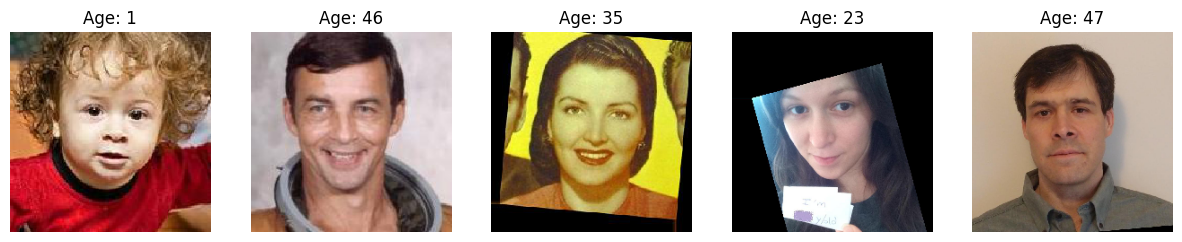

In [3]:
# Define directory containing images
image_dir = "/datasets/faces/final_files" 

# Create an ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)  

# Load images using flow_from_dataframe
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=df_labels,
    directory=image_dir,
    x_col="file_name",
    y_col="real_age",
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw",
    seed=42
)

# Display a few sample images from the dataset
def display_sample_images(generator, num_images=5):
    images, ages = next(generator) 
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i]) 
        plt.title(f"Age: {int(ages[i])}")  
        plt.axis("off")
    
    plt.show()

# display sample images
display_sample_images(train_gen_flow)

***
## EDA

Missing values:
 file_name    0
real_age     0
dtype: int64


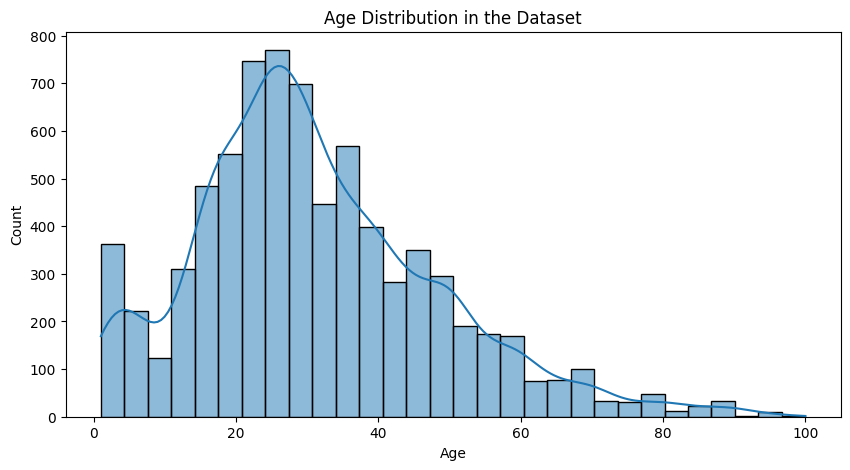

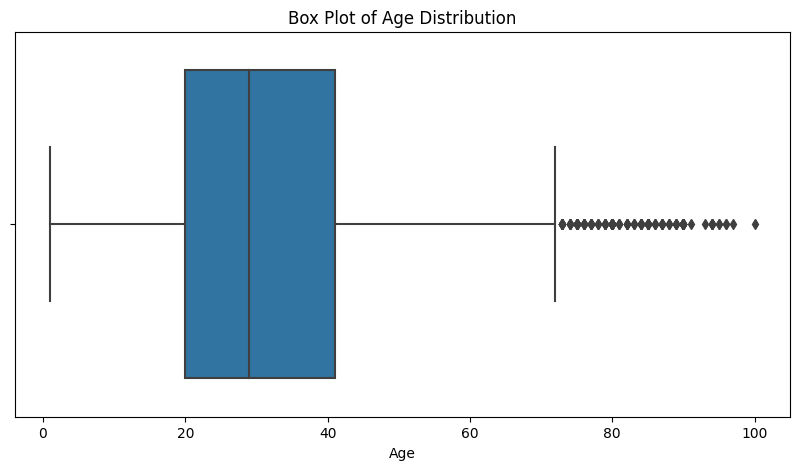

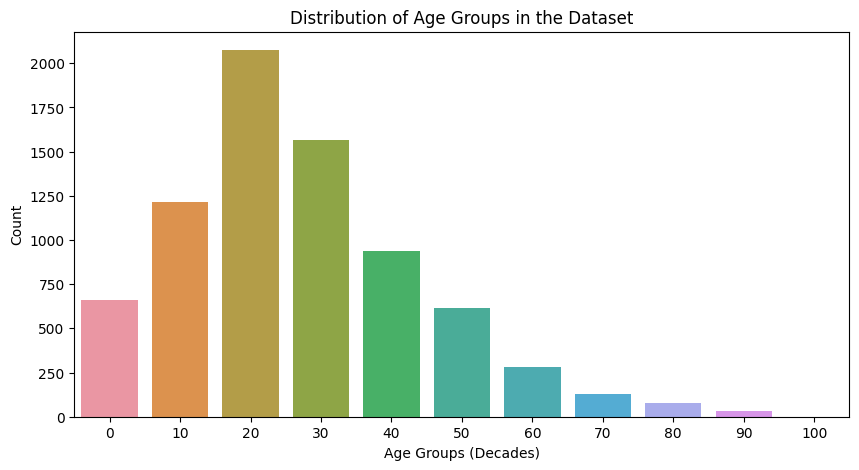

In [4]:
# Check for missing values
missing_values = df_labels.isnull().sum()
print("Missing values:\n", missing_values)

# Summary statistics for age
df_labels['real_age'].describe()

# Plot the age distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_labels['real_age'], bins=30, kde=True)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution in the Dataset")
plt.show()

# Box Plot for age distribution
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_labels['real_age'])
plt.xlabel("Age")
plt.title("Box Plot of Age Distribution")
plt.show()

# Age distribution by decades
df_labels['age_group'] = (df_labels['real_age'] // 10) * 10  # Group ages into bins of 10
plt.figure(figsize=(10, 5))
sns.countplot(x=df_labels['age_group'], order=sorted(df_labels['age_group'].unique()))
plt.xlabel("Age Groups (Decades)")
plt.ylabel("Count")
plt.title("Distribution of Age Groups in the Dataset")
plt.show()

### EDA Key Findings

**Age Distribution:**

- The dataset includes a wide range of ages, with a higher concentration of younger individuals.
- The distribution shows a peak in the early 20s, with a gradual decline as age increases.

**Outliers:**

- The box plot reveals that there are some extreme values in the dataset, particularly for older individuals (80+ years).
- These could impact model training and should be monitored.

**Age Groups:**

- When segmented into age groups by decades, the majority of the dataset consists of individuals aged 10-40.
- Older age groups (70+) are underrepresented, which could influence model accuracy for these categories.

***
## Modelling
Define functions for:
1. Loading training & validation data
2. Creating the CNN model (ResNet50)
3. Training the model

#### Loading training & validation data

In [6]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """

    # Load labels
    labels = pd.read_csv(f"{path}/labels.csv")

    # Define ImageDataGenerator with augmentations
    train_datagen = ImageDataGenerator(
        rescale=1./255,       
        rotation_range=20,   
        width_shift_range=0.2, 
        height_shift_range=0.2,
        horizontal_flip=True,  
        zoom_range=0.2,       
        validation_split=0.2   
    )

    # Load training images using flow_from_dataframe
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f"{path}/final_files",
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),  
        batch_size=32,
        class_mode="raw",  
        subset="training",
        seed=42
    )

    return train_gen_flow

In [7]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    # Load labels
    labels = pd.read_csv(f"{path}/labels.csv")

    # Define ImageDataGenerator 
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    # Load validation images using flow_from_dataframe
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f"{path}/final_files",
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw", 
        subset="validation",
        seed=42
    )

    return test_gen_flow

#### Creating the CNN model (ResNet50)

In [8]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    # Load pretrained ResNet50 
    backbone = ResNet50(
        weights="imagenet", 
        input_shape=input_shape,
        include_top=False
    )

    # Define the model
    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(128, activation="relu"),  
        Dense(1, activation="relu") 
    ])

    # Compile the model
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

    return model

#### Training the model

In [9]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    # Set steps per epoch if not provided
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)

    if validation_steps is None:
        validation_steps = len(test_data)

    # Train the model
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    return model

***
## Prepare the Script to Run on the GPU Platform
1. Prepare script for the GPU platform (Google Colab)
2. Run training on the GPU 
3. Analyze training results (plot metrics & check MAE)

#### Script preparation for Google Colab

In [10]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')
        
print("Training script 'run_model_on_gpu.py' has been generated successfully.")

Training script 'run_model_on_gpu.py' has been generated successfully.


#### Run training on the GPU and acquire output

Below are the training logs obtained from running the model on Google Colab's GPU.

Epoch 1/20
190/190 ━━━━━━━━━━━━━ 195s 686ms/step - loss: 325.4233 - mae: 13.6344 - val_loss: 320.4138 - val_mae: 13.2877

Epoch 2/20
190/190 ━━━━━━━━━━━━━ 141s 519ms/step - loss: 172.2547 - mae: 9.9824 - val_loss: 292.0168 - val_mae: 12.9318

Epoch 3/20
190/190 ━━━━━━━━━━━━━ 142s 517ms/step - loss: 148.9431 - mae: 9.3234 - val_loss: 288.5985 - val_mae: 13.4191

Epoch 4/20
190/190 ━━━━━━━━━━━━━ 143s 520ms/step - loss: 133.6849 - mae: 8.8375 - val_loss: 223.7102 - val_mae: 11.7486

Epoch 5/20
190/190 ━━━━━━━━━━━━━ 99s 519ms/step - loss: 127.0789 - mae: 8.5171 - val_loss: 186.4571 - val_mae: 10.1909

Epoch 6/20
190/190 ━━━━━━━━━━━━━ 141s 515ms/step - loss: 123.9936 - mae: 8.4685 - val_loss: 100.3883 - val_mae: 7.6158

Epoch 7/20
190/190 ━━━━━━━━━━━━━ 142s 516ms/step - loss: 114.8728 - mae: 8.1924 - val_loss: 180.0744 - val_mae: 9.8415

Epoch 8/20
190/190 ━━━━━━━━━━━━━ 143s 521ms/step - loss: 109.6258 - mae: 7.9617 - val_loss: 121.4954 - val_mae: 8.0897

Epoch 9/20
190/190 ━━━━━━━━━━━━━ 141s 516ms/step - loss: 103.1086 - mae: 7.7765 - val_loss: 151.4116 - val_mae: 9.2429

Epoch 10/20
190/190 ━━━━━━━━━━━━━ 98s 515ms/step - loss: 105.9946 - mae: 7.7816 - val_loss: 97.0998 - val_mae: 7.5402

Epoch 11/20
190/190 ━━━━━━━━━━━━━ 142s 516ms/step - loss: 96.8854 - mae: 7.4969 - val_loss: 112.1800 - val_mae: 7.9314

Epoch 12/20
190/190 ━━━━━━━━━━━━━ 141s 513ms/step - loss: 91.0186 - mae: 7.2108 - val_loss: 141.9712 - val_mae: 8.9240

Epoch 13/20
190/190 ━━━━━━━━━━━━━ 98s 513ms/step - loss: 95.7323 - mae: 7.4533 - val_loss: 204.1244 - val_mae: 10.8572

Epoch 14/20
190/190 ━━━━━━━━━━━━━ 98s 512ms/step - loss: 101.0529 - mae: 7.4415 - val_loss: 84.7090 - val_mae: 6.8738

Epoch 15/20
190/190 ━━━━━━━━━━━━━ 143s 516ms/step - loss: 80.9264 - mae: 6.8249 - val_loss: 104.9275 - val_mae: 7.9404

Epoch 16/20
190/190 ━━━━━━━━━━━━━ 142s 519ms/step - loss: 85.7027 - mae: 7.0164 - val_loss: 90.6221 - val_mae: 7.2003

Epoch 17/20
190/190 ━━━━━━━━━━━━━ 141s 513ms/step - loss: 86.8268 - mae: 7.0308 - val_loss: 100.2881 - val_mae: 7.3973

Epoch 18/20
190/190 ━━━━━━━━━━━━━ 142s 514ms/step - loss: 79.0104 - mae: 6.7118 - val_loss: 111.5398 - val_mae: 8.3611

Epoch 19/20
190/190 ━━━━━━━━━━━━━ 143s 519ms/step - loss: 78.6589 - mae: 6.7632 - val_loss: 84.6437 - val_mae: 6.8376

Epoch 20/20
190/190 ━━━━━━━━━━━━━ 142s 519ms/step - loss: 76.6749 - mae: 6.7088 - val_loss: 91.8131 - val_mae: 7.1227

#### Analyze training results (plot metrics & check MAE)

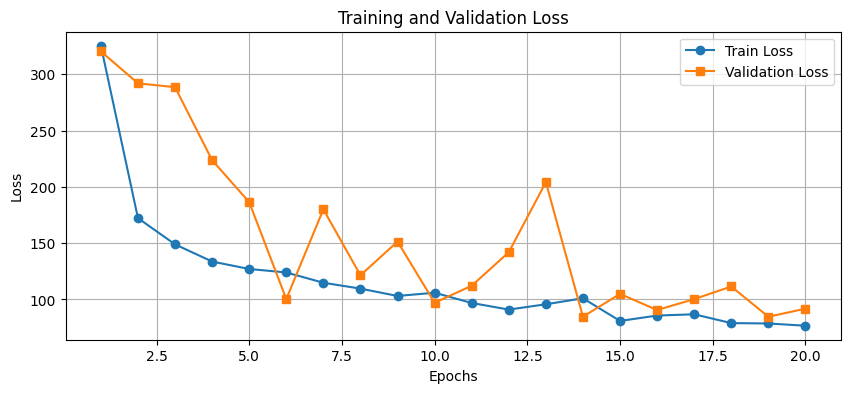

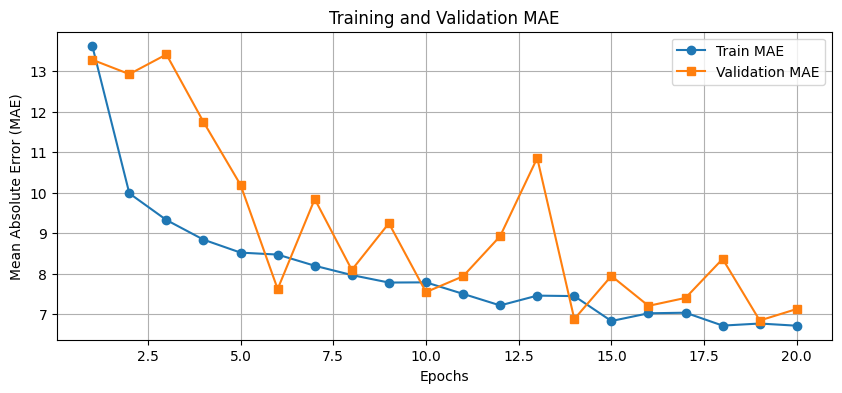

In [11]:
# Training logs extracted 
epochs = np.arange(1, 21)
train_loss = [
    325.4233, 172.2547, 148.9431, 133.6849, 127.0789, 123.9936, 114.8728,
    109.6258, 103.1086, 105.9946, 96.8854, 91.0186, 95.7323, 101.0529, 80.9264,
    85.7027, 86.8268, 79.0104, 78.6589, 76.6749
]
val_loss = [
    320.4138, 292.0168, 288.5985, 223.7102, 186.4571, 100.3883, 180.0744,
    121.4954, 151.4116, 97.0998, 112.1800, 141.9712, 204.1244, 84.7090,
    104.9275, 90.6221, 100.2881, 111.5398, 84.6437, 91.8131
]
train_mae = [
    13.6344, 9.9824, 9.3234, 8.8375, 8.5171, 8.4685, 8.1924, 7.9617, 7.7765,
    7.7816, 7.4969, 7.2108, 7.4533, 7.4415, 6.8249, 7.0164, 7.0308, 6.7118,
    6.7632, 6.7088
]
val_mae = [
    13.2877, 12.9318, 13.4191, 11.7486, 10.1909, 7.6158, 9.8415, 8.0897,
    9.2429, 7.5402, 7.9314, 8.9240, 10.8572, 6.8738, 7.9404, 7.2003, 7.3973,
    8.3611, 6.8376, 7.1227
]

# Plot Loss 
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_loss, label="Train Loss", marker='o')
plt.plot(epochs, val_loss, label="Validation Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

# Plot MAE 
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_mae, label="Train MAE", marker='o')
plt.plot(epochs, val_mae, label="Validation MAE", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Training and Validation MAE")
plt.legend()
plt.grid()
plt.show()

**Training and Validation Loss**

- The model initially had a very high loss, but it significantly reduced over time.
- There are some fluctuations in validation loss, which may indicate overfitting in certain epochs.

**Training and Validation MAE**

- The MAE decreased over time, meaning the model's age predictions became more accurate.
- The validation MAE stabilized around 7, which suggests reasonable performance.
- A slight gap between training and validation MAE suggests possible room for generalization improvements.

***
## Conclusions
1. Can this model help the customer?
2. Other use cases for the model?
3. Possible improvements?

#### **Can this model help the customer?**
- The model achieves an MAE of ~7.1, meaning that, on average, predictions are 7 years off from the actual age.
- While not precise enough for applications requiring exact age verification (like identity verification), it can still be valuable for broad age group classification (child, teenager, adult, senior).
- The model could be useful for general demographic analysis rather than precise age estimation.

#### **Beyond age prediction, this model could be adapted for:**

- Ad Targeting – Predicts an approximate age range for personalized advertisements.
- Content Filtering – Restricts content based on estimated age (age-restricted videos).
- Retail & Marketing – Analyzes customer demographics in retail stores.
- Face-based Authentication – Could assist in user verification, but would require higher accuracy.

#### **Possible Improvements**

- Increase data augmentation – more transformations could help generalization.
- Use a more advanced model – try EfficientNet or a larger ResNet variant.
- Fine tuning pretrained weights – train on a larger, diverse dataset before fine-tuning on the current dataset.
- Use a regression head with soft labels – instead of predicting a single value, predict an age distribution.

**Final Thoughts**

This model provides a strong starting point for age estimation using computer vision. While its accuracy is not high enough for critical applications, it is still useful for broad age categorization and commercial applications where approximate age is sufficient. With further refinements and access to larger datasets, this approach could be more viable for real-world deployment.
***